In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
from csv import writer
import math
import cmath
import pickle

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

In [11]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)

[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


In [12]:
from sklearn.decomposition import FastICA
import warnings
scaler_obj1=FastICA()
scaler_obj2=FastICA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [13]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [14]:
model = Sequential()
model.add(keras.Input(shape=(1,5)))
model.add(tf.keras.layers.GRU(14,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(.1))
model.add(Dense(7))
model.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model.add(keras.layers.ReLU())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 14)                882       
                                                                 
 dropout_1 (Dropout)         (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 batch_normalization_1 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 7)                 0         
                                                                 
Total params: 1,015
Trainable params: 1,001
Non-trainable params: 14
___________________________________________________

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history2 = model.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 86s 18ms/step - loss: 0.0011 - accuracy: 0.1304 - mse: 3.1131e-06 - mae: 3.0179e-04 - rmse: 5.3541e-04 - val_loss: 8.7620e-04 - val_accuracy: 0.1419 - val_mse: 2.6852e-07 - val_mae: 1.4723e-04 - val_rmse: 2.5110e-04
Epoch 2/50
4563/4563 [==============================] - 82s 18ms/step - loss: 7.3171e-04 - accuracy: 0.1404 - mse: 2.0702e-06 - mae: 1.4878e-04 - rmse: 2.5334e-04 - val_loss: 5.9814e-04 - val_accuracy: 0.1421 - val_mse: 2.5089e-07 - val_mae: 1.4595e-04 - val_rmse: 2.4869e-04
Epoch 3/50
4563/4563 [==============================] - 78s 17ms/step - loss: 4.8650e-04 - accuracy: 0.1407 - mse: 1.4339e-06 - mae: 1.4752e-04 - rmse: 2.5077e-04 - val_loss: 3.8401e-04 - val_accuracy: 0.1420 - val_mse: 2.4020e-07 - val_mae: 1.4585e-04 - val_rmse: 2.4856e-04-04 - accuracy: 0.1406 - mse: 1.4701e-
Epoch 4/50
4563/4563 [==============================] - 80s 18ms/step - loss: 3.0599e-04 - accuracy: 0.1407 - mse: 1.2619e-06 - mae: 1.472

4563/4563 [==============================] - 55s 12ms/step - loss: 7.5082e-07 - accuracy: 0.1406 - mse: 7.4841e-07 - mae: 1.4619e-04 - rmse: 2.4877e-04 - val_loss: 2.2920e-07 - val_accuracy: 0.1420 - val_mse: 2.2666e-07 - val_mae: 1.4561e-04 - val_rmse: 2.4821e-04
Epoch 31/50
4563/4563 [==============================] - 56s 12ms/step - loss: 7.5082e-07 - accuracy: 0.1406 - mse: 7.4841e-07 - mae: 1.4619e-04 - rmse: 2.4877e-04 - val_loss: 2.2920e-07 - val_accuracy: 0.1420 - val_mse: 2.2666e-07 - val_mae: 1.4561e-04 - val_rmse: 2.4821e-04
Epoch 32/50
4563/4563 [==============================] - 55s 12ms/step - loss: 7.5081e-07 - accuracy: 0.1406 - mse: 7.4841e-07 - mae: 1.4619e-04 - rmse: 2.4877e-04 - val_loss: 2.2913e-07 - val_accuracy: 0.1420 - val_mse: 2.2666e-07 - val_mae: 1.4561e-04 - val_rmse: 2.4821e-04
Epoch 33/50
4563/4563 [==============================] - 57s 12ms/step - loss: 7.5082e-07 - accuracy: 0.1406 - mse: 7.4841e-07 - mae: 1.4619e-04 - rmse: 2.4876e-04 - val_loss: 2.289

In [16]:
model.evaluate(x_test,y_test)

13518/13518 [==============================] - 85s 6ms/step - loss: 2.2568e-07 - accuracy: 0.1412 - mse: 2.2313e-07 - mae: 1.4529e-04 - rmse: 2.4746e-04: 7s - loss: 2.3220e-07 - accuracy: 0.1412 - mse: 2.2965e-07 - m


[2.2567631674519362e-07,
 0.14123259484767914,
 2.2312762837373157e-07,
 0.0001452932192478329,
 0.00024746463168412447]

In [17]:
model.evaluate(x_train,y_train)

40554/40554 [==============================] - 255s 6ms/step - loss: 6.9876e-07 - accuracy: 0.1408 - mse: 6.9622e-07 - mae: 1.4614e-04 - rmse: 2.4871e-04


[6.987613119235903e-07,
 0.14077988266944885,
 6.962179668335011e-07,
 0.00014613542589358985,
 0.00024871184723451734]

In [18]:
df1=pd.DataFrame(history2.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(history2.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(history2.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(history2.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(history2.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(history2.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(history2.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(history2.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(history2.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(history2.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,1.052976e-03,8.761995e-04,0.130423,0.141945,3.113095e-06,2.685237e-07,0.000302,0.000147,0.000535,2.685237e-07
1,7.317074e-04,5.981417e-04,0.140404,0.142069,2.070200e-06,2.508901e-07,0.000149,0.000146,0.000253,2.508901e-07
2,4.864951e-04,3.840071e-04,0.140673,0.142022,1.433948e-06,2.402022e-07,0.000148,0.000146,0.000251,2.402022e-07
3,3.059904e-04,2.319949e-04,0.140681,0.142022,1.261895e-06,2.324725e-07,0.000147,0.000146,0.000250,2.324725e-07
4,1.732460e-04,1.215748e-04,0.140647,0.142024,1.050968e-06,2.283051e-07,0.000147,0.000146,0.000250,2.283051e-07
5,8.532529e-05,5.415666e-05,0.140637,0.142024,9.154333e-07,2.267949e-07,0.000147,0.000146,0.000250,2.267949e-07
6,3.377959e-05,1.751529e-05,0.140641,0.142025,8.217477e-07,2.266551e-07,0.000146,0.000146,0.000249,2.266551e-07
7,1.035849e-05,4.255978e-06,0.140639,0.142025,7.877641e-07,2.266551e-07,0.000146,0.000146,0.000249,2.266551e-07
8,2.687849e-06,8.646246e-07,0.140642,0.142025,7.556629e-07,2.266551e-07,0.000146,0.000146,0.000249,2.266551e-07
9,1.035324e-06,2.526431e-07,0.140636,0.142025,7.484012e-07,2.266551e-07,0.000146,0.000146,0.000249,2.266551e-07


In [19]:
df1.to_excel("GRU_tanh_mse.xlsx")

In [20]:
model_json = model.to_json()
with open("gru_tanh_mse.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gru_tanh_mse.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('gru_tanh_mse.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gru_tanh_mse.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
print(loaded_model.evaluate(x_train, y_train, verbose=0))

Loaded model from disk
[6.987613119235903e-07, 0.14077988266944885, 6.962179668335011e-07, 0.00014613542589358985, 0.00024871184723451734]


In [22]:
print(loaded_model.evaluate(x_test,y_test))

13518/13518 [==============================] - 83s 6ms/step - loss: 2.2568e-07 - accuracy: 0.1412 - mse: 2.2313e-07 - mae: 1.4529e-04 - rmse: 2.4746e-04
[2.2567631674519362e-07, 0.14123259484767914, 2.2312762837373157e-07, 0.0001452932192478329, 0.00024746463168412447]


In [23]:
print(loaded_model.evaluate(x_train,y_train))

40554/40554 [==============================] - 252s 6ms/step - loss: 6.9876e-07 - accuracy: 0.1408 - mse: 6.9622e-07 - mae: 1.4614e-04 - rmse: 2.4871e-04
[6.987613119235903e-07, 0.14077988266944885, 6.962179668335011e-07, 0.00014613542589358985, 0.00024871184723451734]


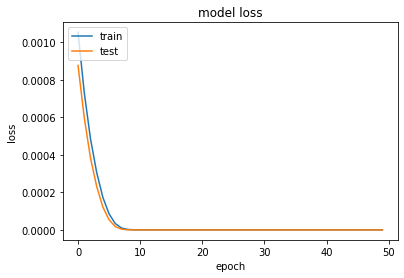

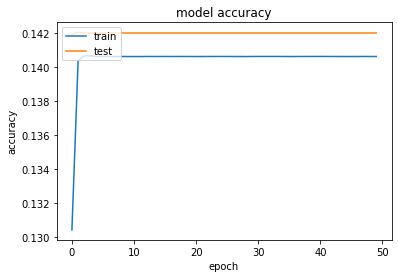

In [24]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=model.predict(x_test)
y_test_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
y_test

array([[[-1.77340634e-04,  5.07019147e-04,  1.27759140e-05, ...,
          3.16324593e-06,  2.56898277e-05, -9.56800334e-06]],

       [[-3.60422755e-05,  2.04729574e-04,  6.22421797e-06, ...,
          5.84373883e-05,  2.45314285e-04,  4.84085828e-05]],

       [[ 7.06964098e-04, -3.04349088e-04, -2.96158730e-05, ...,
          2.30439044e-05,  1.05145526e-04,  2.04113414e-05]],

       ...,

       [[ 2.89730195e-04, -1.13160315e-03, -2.99790869e-05, ...,
          2.17584523e-05,  4.47973454e-05,  3.82158241e-05]],

       [[-2.08169411e-04,  2.86823775e-04,  6.33051425e-06, ...,
          5.54987934e-05,  2.24031460e-04,  4.38175291e-05]],

       [[-2.03736456e-04,  4.60418219e-04,  1.18411659e-05, ...,
         -5.04256497e-06,  1.12555910e-05, -6.02974700e-06]]])

In [27]:
y_test=y_test[:,0]

In [28]:
from numpy import savetxt
savetxt('gru_tanh_mse_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [29]:
from numpy import savetxt
savetxt('gru_tanh_mse_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed